# Iowa house price prediction

In this notebook we used a simple linear regression to predict the price a group of houses in Iowa.

Quantitative and qualitative variables were used for modeling, the qualitative ones were converted into dummies for being used into our model. The strenght of linear correlation with the target variable was used to choose the quantitative variables used. In the case of the qualitative ones, an ANNOVA analysis was used.

We dealed with the outliers using a univariate analysis with the z-core value as indicator.Functions as logarithms and square root were used during the process to get normality and homoscedasticity of the variables.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt


In [2]:
#importing libraries

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_data=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test_data=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# Dealing with missing values

In [5]:
# Getting the missing values per features

Total= train_data.isnull().sum().sort_values(ascending=False)[
    train_data.isnull().sum().sort_values(ascending=False) !=0]

Percentage=(train_data.isnull().sum().sort_values(ascending=False)/len(train_data) *100)[
    (train_data.isnull().sum().sort_values(ascending=False)/len(train_data)*100)!=0]

missing_values= pd.concat([Total, Percentage],axis=1, keys=['Total', 'Percentage'])

,PoolQC,MiscFeature,Alley,Fence,FireplaceQu,LotFrontage,GarageCond,GarageType,GarageYrBlt,GarageFinish,GarageQual,BsmtExposure,BsmtFinType2,BsmtFinType1,BsmtCond,BsmtQual,MasVnrArea,MasVnrType,Electrical
Total,1453.000000,1406.000000,1369.000000,1179.000000,690.000000,259.000000,81.000000,81.000000,81.000000,81.000000,81.000000,38.000000,38.000000,37.000000,37.000000,37.000000,8.000000,8.000000,1.000000
Percentage,99.520548,96.301370,93.767123,80.753425,47.260274,17.739726,5.547945,5.547945,5.547945,5.547945,5.547945,2.602740,2.602740,2.534247,2.534247,2.534247,0.547945,0.547945,0.068493


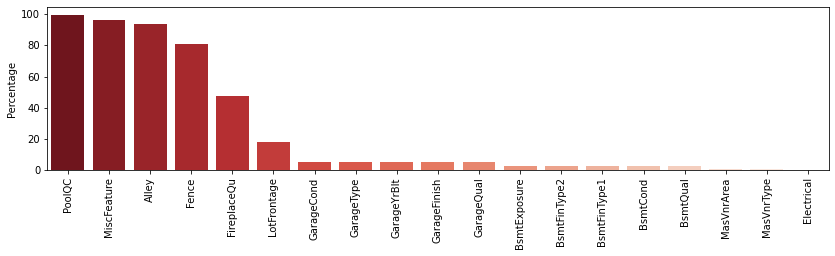

In [6]:
fig, ax= plt.subplots(figsize=(14,3))
sns.barplot(data=missing_values, x=missing_values.index, y='Percentage', palette='Reds_r')
plt.xticks(rotation=90)

display(missing_values.T.style.background_gradient(cmap='Reds',axis=1))

**Analysis**:

* 19 of 81 features have missing values

* 5 features have majority of missing values. Of wich 3 features have more than 90% of missing values.

* Theres thre groups of features (garage features(5), basement features(5) and masonery veneer(2)), whose features have equal amounts of missing values. It would be logical that all those missing values belong to the same samples.
 
* There's one features with just 1 missing values.

## Deleting features with majority of missing values

Trying to replace most of values could lead to strongly skew the data set. Moreover, even if we were able to replace them with an adecuate value, having a feature where most of its values are equal doesn't apport predictive value to the model. For this reason we delete these features.

In [7]:
high_mv_feat= ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']
train_data.drop(labels=high_mv_feat, axis=1, inplace=True)

In [8]:
train_data.shape

(1460, 76)

## Lot frontage

Let's see a little more about this feature

In [9]:
train_data[['LotFrontage']].describe()

,LotFrontage
count,1201.000000
mean,70.049958
std,24.284752
min,21.000000
25%,59.000000
50%,69.000000
75%,80.000000
max,313.000000


We can see that the range of values for lot frontage goes from 21 to 313. If we think that there's a lot of appartments and houses without frontage, it's probable that the missing values refer to these cases. So we'll replace the Nan values with a 0.

In [10]:
#replacing nan values for 0

train_data['LotFrontage'].fillna(value=0, inplace=True)

In [11]:
# Checkpoint

train_data[['LotFrontage']].isnull().sum()

LotFrontage    0
dtype: int64

## Garage related features

Let's see a description of these features

In [12]:
garage_list=['GarageCond','GarageType','GarageYrBlt','GarageFinish','GarageQual']
train_data[garage_list].describe(include='all')

,GarageCond,GarageType,GarageYrBlt,GarageFinish,GarageQual
count,1379,1379,1379.000000,1379,1379
unique,5,6,NaN,3,5
top,TA,Attchd,NaN,Unf,TA
freq,1326,870,NaN,605,1311
mean,NaN,NaN,1978.506164,NaN,NaN
std,NaN,NaN,24.689725,NaN,NaN
min,NaN,NaN,1900.000000,NaN,NaN
25%,NaN,NaN,1961.000000,NaN,NaN
50%,NaN,NaN,1980.000000,NaN,NaN
75%,NaN,NaN,2002.000000,NaN,NaN


We see that we have 4 cathegorical variables and 1 numerical one. 

Cathegorical: One way to fill this values it's  to make a very tedius handwork evaluating other features of the house and using our criterius to decide. Other way, a mucho more simple one, it's to replace the nan values with the most frecuent value.

Numerical: In this case, reaplace the nan values in garage year of construccton with house years of construction makes sense to me.

In [13]:
# Replacing nan values based frecuency

train_data['GarageCond'].fillna(value='TA', inplace=True)
train_data['GarageType'].fillna(value='Attchd', inplace=True)
train_data['GarageFinish'].fillna(value='Unf', inplace=True)
train_data['GarageQual'].fillna(value='TA', inplace=True)

# Replacing nan based on other features

index=train_data[train_data['GarageYrBlt'].isnull()].index

for i in index:
    value=train_data.loc[i, 'YearBuilt']
    train_data.loc[i, 'GarageYrBlt']= value

In [14]:
# Checkpoint

train_data[garage_list].isnull().sum()

GarageCond      0
GarageType      0
GarageYrBlt     0
GarageFinish    0
GarageQual      0
dtype: int64

## Basement related features

Let's repeat the analysis

In [15]:
# Features description

basement_list=['BsmtExposure','BsmtFinType2','BsmtFinType1','BsmtCond','BsmtQual']
train_data[basement_list].describe()

,BsmtExposure,BsmtFinType2,BsmtFinType1,BsmtCond,BsmtQual
count,1422,1422,1423,1423,1423
unique,4,6,6,4,4
top,No,Unf,Unf,TA,TA
freq,953,1256,430,1311,649


In this case all the features are cathegorical, so we can replace nan values by frecuency

In [16]:
# Replacing nan values based frecuency

train_data['BsmtExposure'].fillna(value='No', inplace=True)
train_data['BsmtFinType2'].fillna(value='Unf', inplace=True)
train_data['BsmtFinType1'].fillna(value='Unf', inplace=True)
train_data['BsmtCond'].fillna(value='TA', inplace=True)
train_data['BsmtQual'].fillna(value='TA', inplace=True)

In [17]:
# Checkpoint

train_data[basement_list].isnull().sum()

BsmtExposure    0
BsmtFinType2    0
BsmtFinType1    0
BsmtCond        0
BsmtQual        0
dtype: int64

## Masonery related features

Let's see the features chareacteristics

In [18]:
mas_list=['MasVnrArea', 'MasVnrType']
train_data[mas_list].describe(include='all')

,MasVnrArea,MasVnrType
count,1452.000000,1452
unique,NaN,4
top,NaN,None
freq,NaN,864
mean,103.685262,NaN
std,181.066207,NaN
min,0.000000,NaN
25%,0.000000,NaN
50%,0.000000,NaN
75%,166.000000,NaN


In this case we can conclude that the majority of samples don't have masonery veneer and they use values '0' and 'None' to represent this fact. For this reason we'll use this values to replace the nan values.

In [19]:
train_data['MasVnrArea'].fillna(value=0, inplace=True)
train_data['MasVnrType'].fillna(value='None', inplace=True)

In [20]:
# Checkpoint
train_data[mas_list].isnull().sum()

MasVnrArea    0
MasVnrType    0
dtype: int64

## Electrical

Here we go again

In [21]:
train_data[['Electrical']].describe()

,Electrical
count,1459
unique,5
top,SBrkr
freq,1334


We have a categorical feature we don't know much about, so we'll replace by frecuency

In [22]:
train_data['Electrical'].fillna(value='SBrkr', inplace=True)

In [23]:
# Checkpoint

train_data['Electrical'].isnull().sum()

0

## General checkpoint

In [24]:
print('The number of missing values in this data set is: ', train_data.isnull().sum().sum())

The number of missing values in this data set is:  0


# Data Exploration

In [25]:
train_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,57.623288,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,34.664304,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,0.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,42.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,63.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [26]:
train_data.shape

(1460, 76)

38 of the 76 colums belong to numerical features whereas the categorical features have 38 columns. We will analyse them separately.

## Analyzing numerical features

Let's see the linear relationship between features

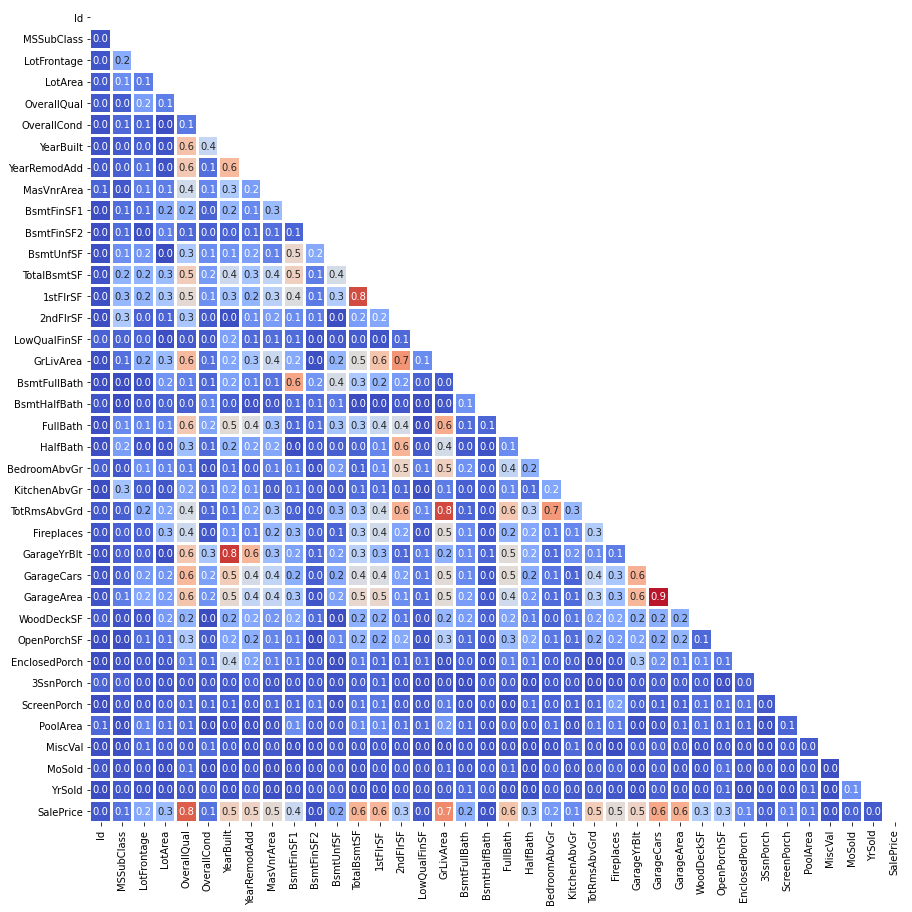

In [27]:
#correlation matrix
corrmat=train_data.corr()
corrmat=corrmat.transform(abs)
mask=np.triu(corrmat)
f, ax= plt.subplots(figsize=(15,15))
sns.heatmap(corrmat,
            vmax=0.9,
            cmap='coolwarm',
            cbar=False,
            mask=mask,
            annot=True,
            fmt='.1f',
            linewidths=2,
            square=True)

We could see there are a lot of features that have very weak linear relation with 'SalePrice' (the variable we want to predcit). We will discart the variable with a correlation index lower than 0.5

In [28]:
# Deleting features

low_corr_feat=corrmat[corrmat['SalePrice']<0.5].index
train_data.drop(labels=low_corr_feat, axis=1, inplace=True)

Now, it's time to carry out a more complete analysis over the selected features.

In [29]:
# Getting the features with a bigger correlation with 'SalePrice'

corrmat.sort_values(by='SalePrice', axis=0, ascending=False, inplace=True)
col=corrmat[corrmat['SalePrice']>=0.5].index
col

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'GarageYrBlt', 'YearRemodAdd'],
      dtype='object')

## Linear regrression assumptions

Using linear regression to make predictions always will return a value, independently of the data we use. It depends on us to determine if using this model makes sense or not. Using a linear regression model makes sense only if the following conditions are met:


1. The Quantitative data condition
1. The straight enough condition (linearity)
1. The oulier condiditinon
1. Normality
1. Independence of error
1. Homocedasticity
1. Normallity of Error Distribution




### The quantitative data condition

We can only perfom regression on quantitative variables. Between our selected features there are three variables,'YearBuilt', 'YearRemodAdd' and 'GarageYrBlt'. that seems quantitative but actually they're categorical. If we want to use them in our model we need to transform them into numerical features.

One option it's to get dummies of from its variable but these will create a new variable for each instance of the orginal variables. This implies almost 300 new features, to many for the amount of samples we have. For this reason we will get the age of the houses(from 'YearBuilt'), the age of the garage (from 'GarageYrBuilt') and the time since the last remodelations (from 'YearRemodAdd'), so we get just two new variables.

In [30]:
# Getting our new variables

train_data['HouseAge']=2012-train_data['YearBuilt']
train_data['LastRemodTime']= 2012-train_data['YearRemodAdd']
train_data['GarageAge']=2012-train_data['GarageYrBlt']

In [31]:
# Deleting the old ones

train_data.drop(['YearBuilt','YearRemodAdd', 'GarageYrBlt'], axis=1, inplace=True)

In [32]:
col= list(col)
col[9]='HouseAge'
col[10]='GarageAge'
col[11]='LastRemodTime'
col

['SalePrice',
 'OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'FullBath',
 'TotRmsAbvGrd',
 'HouseAge',
 'GarageAge',
 'LastRemodTime']

In [33]:
# Check our new variables

train_data[['HouseAge','LastRemodTime','GarageAge']].head()

,HouseAge,LastRemodTime,GarageAge
0,9,9,9.0
1,36,36,36.0
2,11,10,11.0
3,97,42,14.0
4,12,12,12.0


At this point all our features are **quantitative features and they all have a strong linear relationship** with the dependent variable. Now, the jobs in analyze the data to determine if the others conditions are met, and if not, try to fix it.


### Dealing with outliers

The outliers could come from mistakes during the data collection process or they could be just variance in our dataset. Anayway we will eliminate them.

To remove the ourliers in our dataset we will make an univariate analysis (I'm concious of its limitations but it's a good point to start dealing with ouliers). The mathematical function we'll use to determine what values are ouliers is the z-socre and we establish a treshold z=3

In [34]:
# Importing the function to calculate z-score 

from scipy.stats import zscore

In [35]:
# Calculing the  z-score for each value

z=np.abs(zscore(train_data[col]))
print(z)

[[0.34727322 0.65147924 0.37033344 ... 1.05099379 1.00740512 0.87866809]
 [0.00728832 0.07183611 0.48251191 ... 0.15673371 0.01929955 0.42957697]
 [0.53615372 0.65147924 0.51501256 ... 0.9847523  0.93135292 0.83021457]
 ...
 [1.07761115 0.65147924 1.56964722 ... 1.00249232 1.35021301 1.02402865]
 [0.48852299 0.79515147 0.83278768 ... 0.70440562 1.00797812 0.53949344]
 [0.42084081 0.79515147 0.49393395 ... 0.20759447 0.43758663 0.96256569]]


In [36]:
# the shape before the cleaning
train_data.shape

(1460, 50)

In [37]:
# Deleting the rows where there are outliers

train_data = train_data[(z<3).all(axis=1)]

# Reseting the index

train_data.reset_index(drop= True, inplace=True)

# The shape after the cleaning

train_data.shape

(1406, 50)

### Normality, independences of error, homoscedasticity and normallity of error distribution

We will evaluate this conditions through visualization tools. Our initial analysis will be with scatter plots. With these plots we will be able to visualize the phenomenoms of homoscedasticiy (there must similar variance of "SalePrice" throughout the values on the x axis), independence of error ( if we see some pattern in the errors there's not independence) and normality of error distribution (for each value of x, the values of 'SalePrice' must have a normail distribution).

In [38]:
col

['SalePrice',
 'OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'FullBath',
 'TotRmsAbvGrd',
 'HouseAge',
 'GarageAge',
 'LastRemodTime']

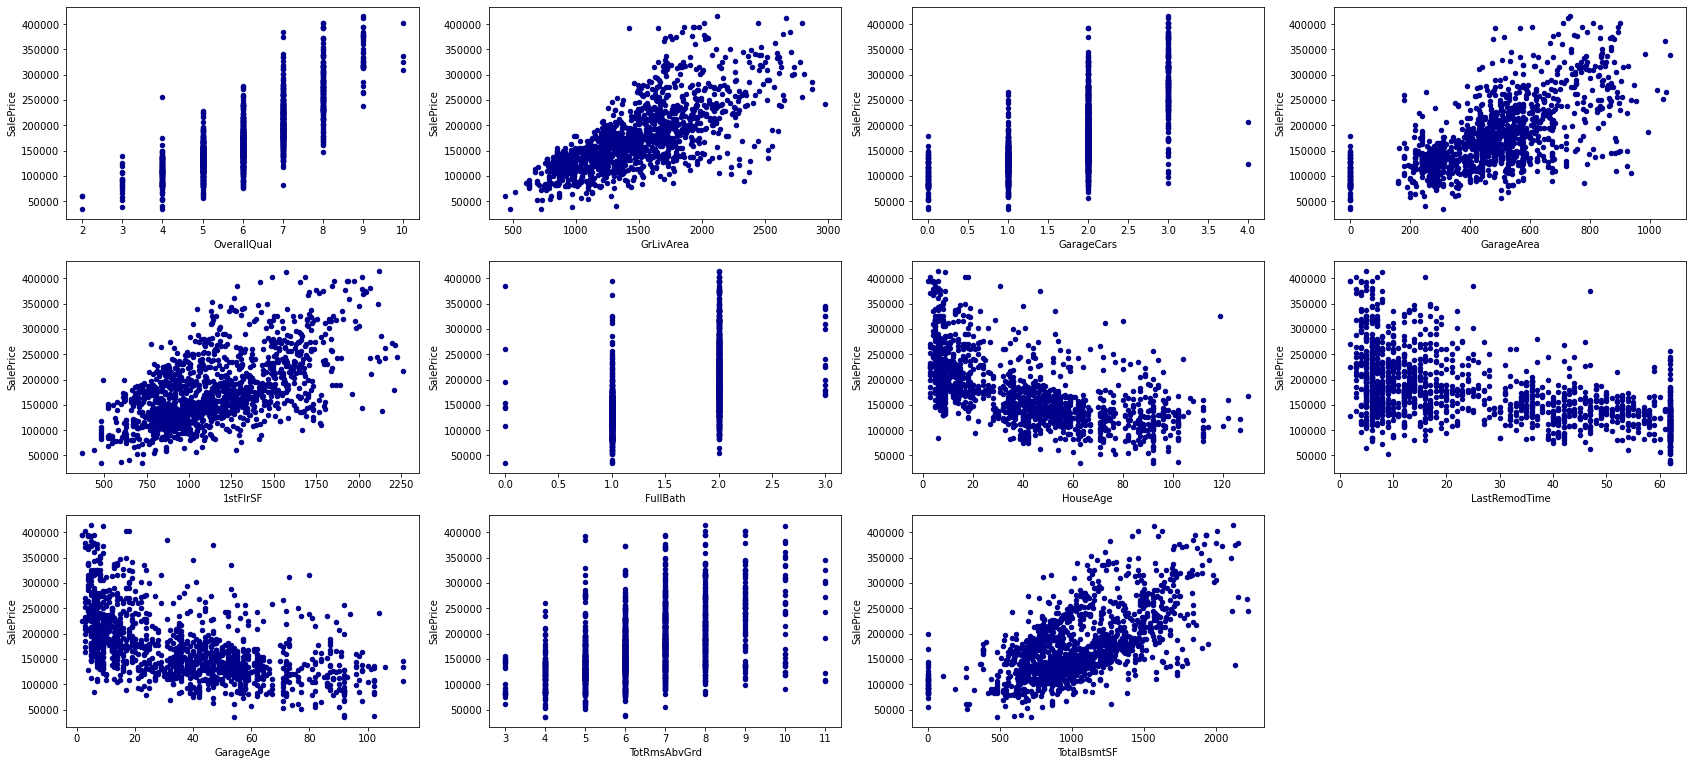

In [39]:
fig = plt.figure()

ax1= fig.add_subplot(3,4,1)
ax2= fig.add_subplot(3,4,2)
ax3= fig.add_subplot(3,4,3)
ax4= fig.add_subplot(3,4,4)
ax5= fig.add_subplot(3,4,5)
ax6= fig.add_subplot(3,4,6)
ax7= fig.add_subplot(3,4,7)
ax8= fig.add_subplot(3,4,8)
ax9= fig.add_subplot(3,4,9)
ax10= fig.add_subplot(3,4,10)
ax11= fig.add_subplot(3,4,11)


columns=['OverallQual', 'GrLivArea', 'GarageCars', '1stFlrSF', 'FullBath', 'HouseAge', 'LastRemodTime']

# Subplot 1

train_data.plot(kind='scatter', y='SalePrice', x= 'OverallQual', ax= ax1, figsize=(15,10), color='darkblue')
ax.set_title('OverallQual vs Sale Price')
ax.set_xlabel('OverallQual')
ax.set_ylabel('Sales Price')

# Subplot 2

train_data.plot(kind='scatter', y='SalePrice', x= 'GrLivArea', ax= ax2   , figsize=(15,10), color='darkblue')
ax.set_title('GrLivArea vs Sale Price')
ax.set_xlabel('GrLivArea')
ax.set_ylabel('Sales Price')

# Subplot 3

train_data.plot(kind='scatter', y='SalePrice', x='GarageCars'    , ax=  ax3  , figsize=(15,10), color='darkblue')
ax.set_title('GarageCars vs Sale Price')
ax.set_xlabel('GarageCars')
ax.set_ylabel('Sales Price')

# Subplot 4

train_data.plot(kind='scatter', y='SalePrice', x= 'GarageArea'   , ax= ax4   , figsize=(15,10), color='darkblue')
ax.set_title('GarageArea vs Sale Price')
ax.set_xlabel('GarageArea')
ax.set_ylabel('Sales Price')

# Subplot 5

train_data.plot(kind='scatter', y='SalePrice', x='1stFlrSF'    , ax= ax5   , figsize=(15,10), color='darkblue')
ax.set_title('1stFlrSF vs Sale Price')
ax.set_xlabel('1stFlrSF')
ax.set_ylabel('Sales Price')

# Subplot 6

train_data.plot(kind='scatter', y='SalePrice', x= 'FullBath'   , ax= ax6   , figsize=(15,10), color='darkblue')
ax.set_title('FullBath vs Sale Price')
ax.set_xlabel('FullBath')
ax.set_ylabel('Sales Price')

# Subplot 7

train_data.plot(kind='scatter', y='SalePrice', x= 'HouseAge'   , ax= ax7   , figsize=(15,10), color='darkblue')
ax.set_title('HouseAge vs Sale Price')
ax.set_xlabel('HouseAge')
ax.set_ylabel('Sales Price')

# Subplot 8

train_data.plot(kind='scatter', y='SalePrice', x= 'LastRemodTime'   , ax= ax8   , figsize=(15,10), color='darkblue')
ax.set_title('LastRemodTime vs Sale Price')
ax.set_xlabel('LastRemodTime')
ax.set_ylabel('Sales Price')

#Subplot 9

train_data.plot(kind='scatter', y='SalePrice', x= 'GarageAge'   , ax= ax9   , figsize=(15,10), color='darkblue')
ax.set_title('GarageAge vs Sale Price')
ax.set_xlabel('GarageAge')
ax.set_ylabel('Sales Price')



#Subplot 10

train_data.plot(kind='scatter', y='SalePrice', x= 'TotRmsAbvGrd'   , ax= ax10   , figsize=(15,10), color='darkblue')
ax.set_title('TotRmsAbvGrd vs Sale Price')
ax.set_xlabel('TotRmsAbvGrd')
ax.set_ylabel('Sales Price')

#Subplot 11

train_data.plot(kind='scatter', y='SalePrice', x= 'TotalBsmtSF'   , ax= ax11   , figsize=(15,10), color='darkblue')
ax.set_title('TotalBsmtSF vs Sale Price')
ax.set_xlabel('TotalBsmtSF')
ax.set_ylabel('Sales Price')



plt.subplots_adjust(left=1, bottom=1, right=2.5, top=2, wspace=None, hspace=None)
plt.show()

In the plots we can see that the main problem is the heterocedasticity (or lack of homoscedasticity). This phenomenom appears on 7 of the 11 plots ('GrLiveArea', 'GarageArea', '1stFirSf', 'HouseAge', 'LastRemodTime', 'HouseAge', 'TotalBsmtSF').

Sometimes, just by ensuring normality we solved this kind of problems. So we should analyze the normality before we decide if we can use or not this variables.

### Normality

To analyze the normality of the features we will use two type plots:

1. **Histogram** - To visualize kurtosis and skewness.
1. **Normal probability plot** - Data distribution should closely follow the diagonal that represents the normal distribution.

In [40]:
# Importing the function to make normal probability plots

from scipy.stats import probplot

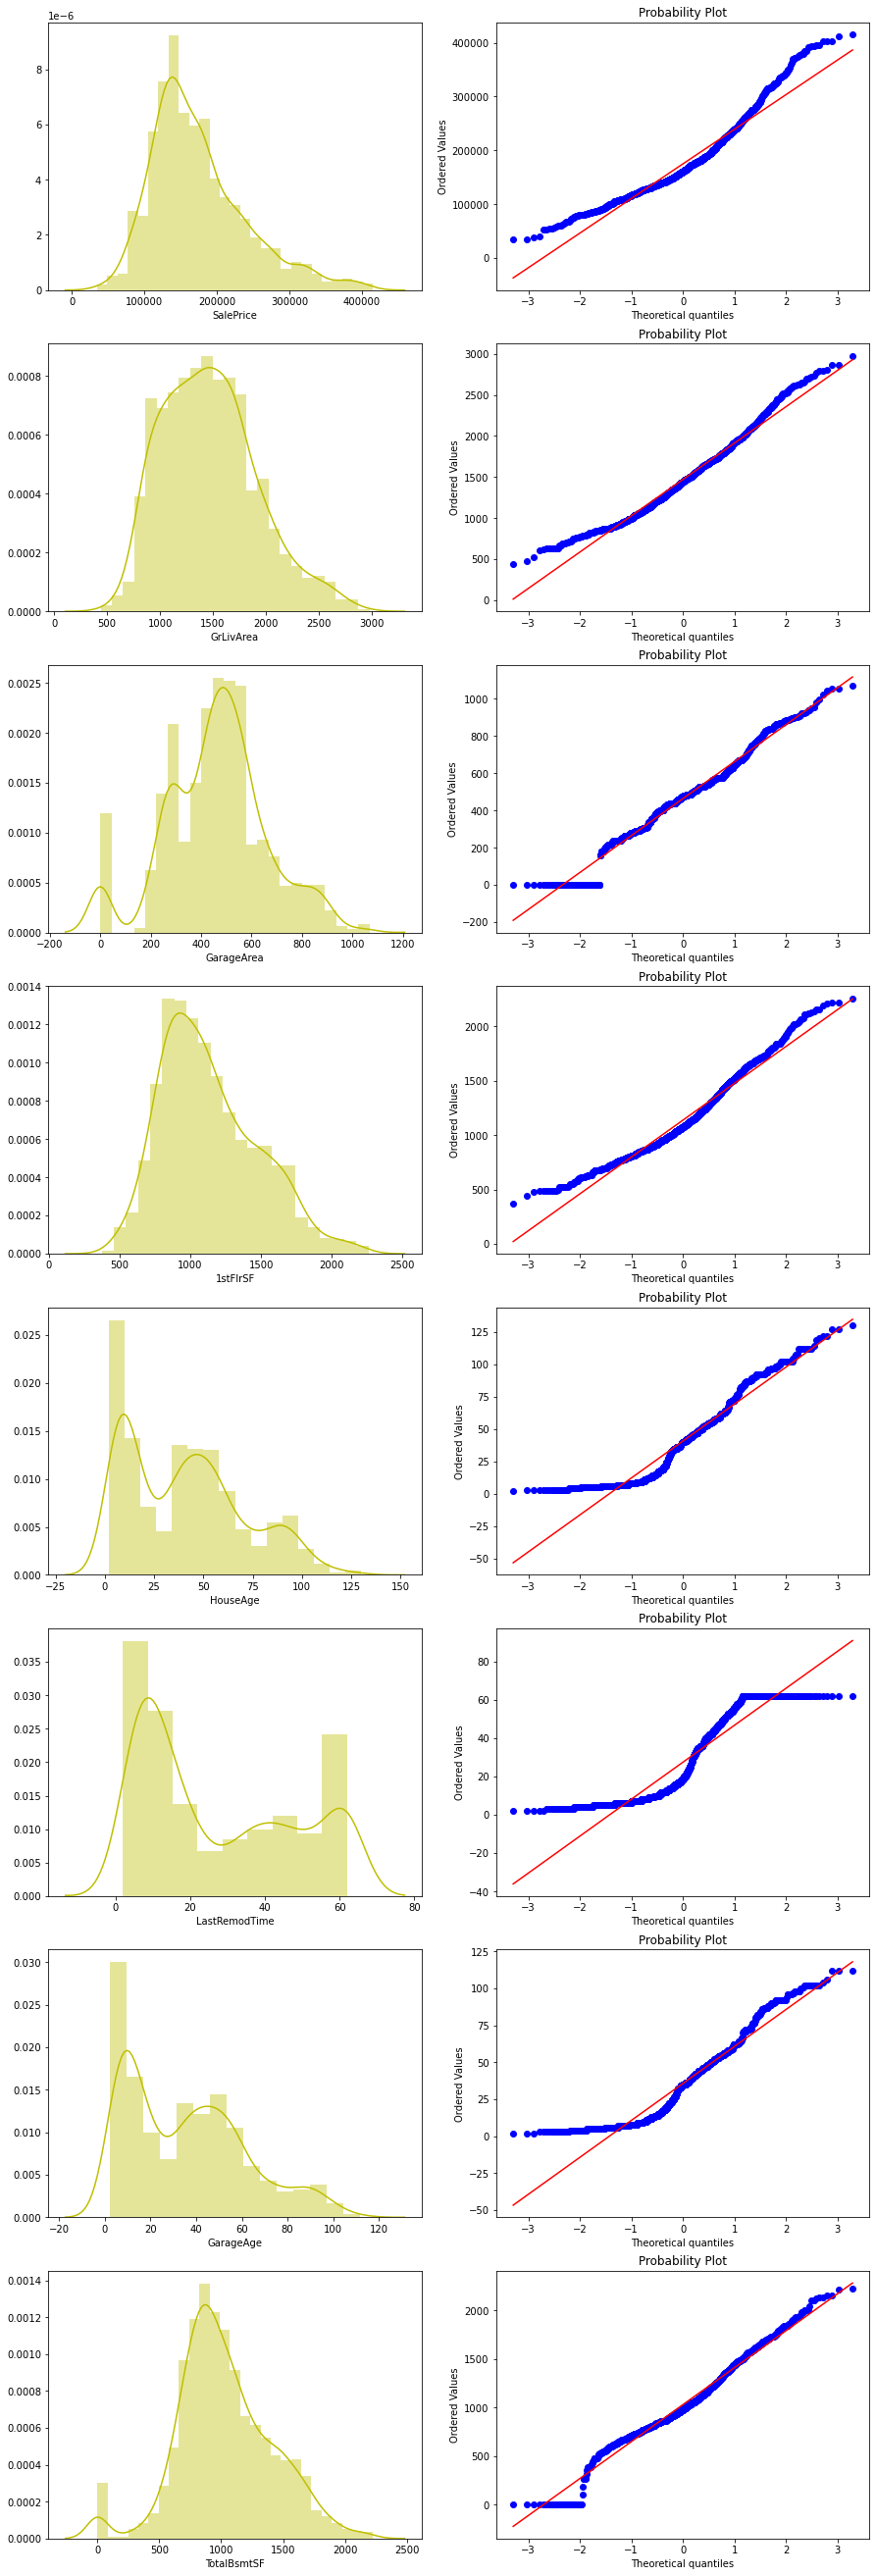

In [41]:
# Fist glance

fig1=plt.figure(figsize=(15,15))
ax1= fig1.add_subplot(8,2,1)
ax2= fig1.add_subplot(8,2,2)
ax3= fig1.add_subplot(8,2,3)
ax4= fig1.add_subplot(8,2,4)
ax5= fig1.add_subplot(8,2,5)
ax6= fig1.add_subplot(8,2,6)
ax7= fig1.add_subplot(8,2,7)
ax8= fig1.add_subplot(8,2,8)
ax9= fig1.add_subplot(8,2,9)
ax10= fig1.add_subplot(8,2,10)
ax11= fig1.add_subplot(8,2,11)
ax12= fig1.add_subplot(8,2,12)
ax13= fig1.add_subplot(8,2,13)
ax14= fig1.add_subplot(8,2,14)
ax15= fig1.add_subplot(8,2,15)
ax16= fig1.add_subplot(8,2,16)

sns.distplot(train_data['SalePrice'],color='y', ax= ax1)
probplot(train_data['SalePrice'], plot= ax2)

sns.distplot(train_data['GrLivArea'],color='y', ax= ax3)
probplot(train_data['GrLivArea'], plot= ax4)

sns.distplot(train_data['GarageArea'],color='y', ax= ax5)
probplot(train_data['GarageArea'], plot= ax6)

sns.distplot(train_data['1stFlrSF'],color='y', ax= ax7)
probplot(train_data['1stFlrSF'], plot= ax8)

sns.distplot(train_data['HouseAge'],color='y', ax= ax9)
probplot(train_data['HouseAge'], plot= ax10)

sns.distplot(train_data['LastRemodTime'],color='y', ax= ax11)
probplot(train_data['LastRemodTime'], plot= ax12)

sns.distplot(train_data['GarageAge'],color='y', ax= ax13)
probplot(train_data['GarageAge'], plot= ax14)

sns.distplot(train_data['TotalBsmtSF'],color='y', ax= ax15)
probplot(train_data['TotalBsmtSF'], plot= ax16)

plt.subplots_adjust(left=None, bottom=None, right=None, top=2.5)
plt.show()

We can see 2 different situations:

1. The group 1 ('SalePrice', 'GrLivArea', '1stFlrSF', 'TotalBsmtSF', 'GarageArea') have a positive skewness.
1. The group 2 ('HouseAge', 'LastRemodTime' and 'GarageAge') doesn't have a normal distribution at all. They look like Fisher distribution.

#### Group 1

These features' distribution show positive skewness. In order to give them a normal distribution we'll apply a log transformation. 

In the cases of 'SalePrice', 'GrLivArea' and '1stFlrSF'we could apply the transformation directly, but because there's no logarithm of 0, so with of 'TotalBsmtSF' and 'GarageArea' we should make a preprocess. 

Let's start with the features we could transform directly.

In [42]:
# Applyinh log transformation

train_data['SalePrice']= np.log(train_data['SalePrice'])
train_data['GrLivArea']= np.log(train_data['GrLivArea'])
train_data['1stFlrSF']= np.log(train_data['1stFlrSF'])


In the cases of 'TotalBsmtSF' and 'GagageArea' we cannot apply logarithm directly because they presents many samples with value 0, what means that the house doesn't have basement or gararge. So we will create an auxiliar function wich apply the transformation just to those house with these attributes. Doing this, we'll get normalitty in the features without losing the effect of having or not.

In [43]:
def SelectedLog(x):
    if x>0:
        t=np.log(x)
        return t
    else:
        return x
    
train_data['TotalBsmtSF']= train_data['TotalBsmtSF'].map(SelectedLog)
train_data['GarageArea']= train_data['GarageArea'].map(SelectedLog)

Let's look how the distributions have changed

((array([-3.27913115, -3.02003183, -2.87582749, ...,  2.87582749,
          3.02003183,  3.27913115]),
  array([5.07517382, 5.07517382, 5.09986643, ..., 6.95844839, 6.95939851,
         6.97447891])),
 (0.3631292509068563, 6.12936366005319, 0.9904418888597145))

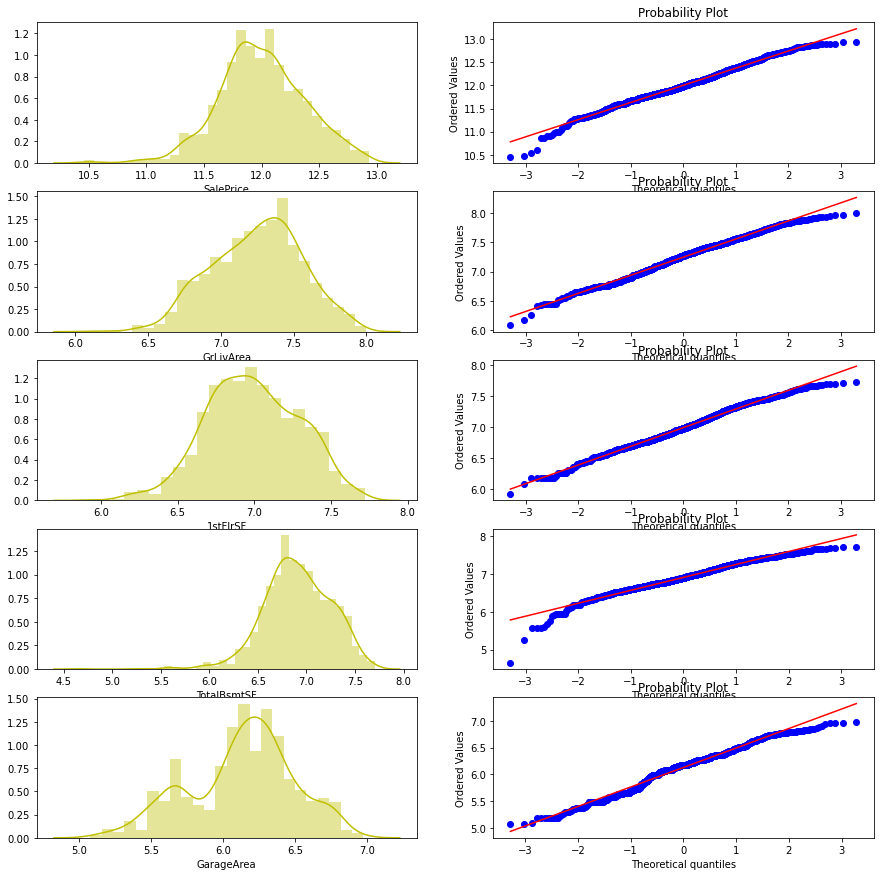

In [44]:
fig2=plt.figure(figsize=(15,15))
ax1= fig2.add_subplot(5,2,1)
ax2= fig2.add_subplot(5,2,2)
ax3= fig2.add_subplot(5,2,3)
ax4= fig2.add_subplot(5,2,4)
ax5= fig2.add_subplot(5,2,5)
ax6= fig2.add_subplot(5,2,6)
ax7= fig2.add_subplot(5,2,7)
ax8= fig2.add_subplot(5,2,8)
ax9= fig2.add_subplot(5,2,9)
ax10= fig2.add_subplot(5,2,10)



sns.distplot(train_data['SalePrice'],color='y', ax= ax1)
probplot(train_data['SalePrice'], plot= ax2)

sns.distplot(train_data['GrLivArea'],color='y', ax= ax3)
probplot(train_data['GrLivArea'], plot= ax4)

sns.distplot(train_data['1stFlrSF'] ,color='y', ax= ax5)
probplot(train_data['1stFlrSF'], plot= ax6)

sns.distplot(train_data[train_data['TotalBsmtSF']>0]['TotalBsmtSF'] ,color='y', ax= ax7)
probplot(train_data[train_data['TotalBsmtSF']>0]['TotalBsmtSF'], plot= ax8)

sns.distplot(train_data[train_data['GarageArea']>0]['GarageArea'] ,color='y', ax= ax9)
probplot(train_data[train_data['GarageArea']>0]['GarageArea'], plot= ax10)

In the plots above we can see that the distributions have changed and now the normal probability curves fit better with theorical ones, so we could say the features have a normal distribution. Now, the question is have this transformation solve the problems of heterocedasticity? Let's see the scatter plots again.

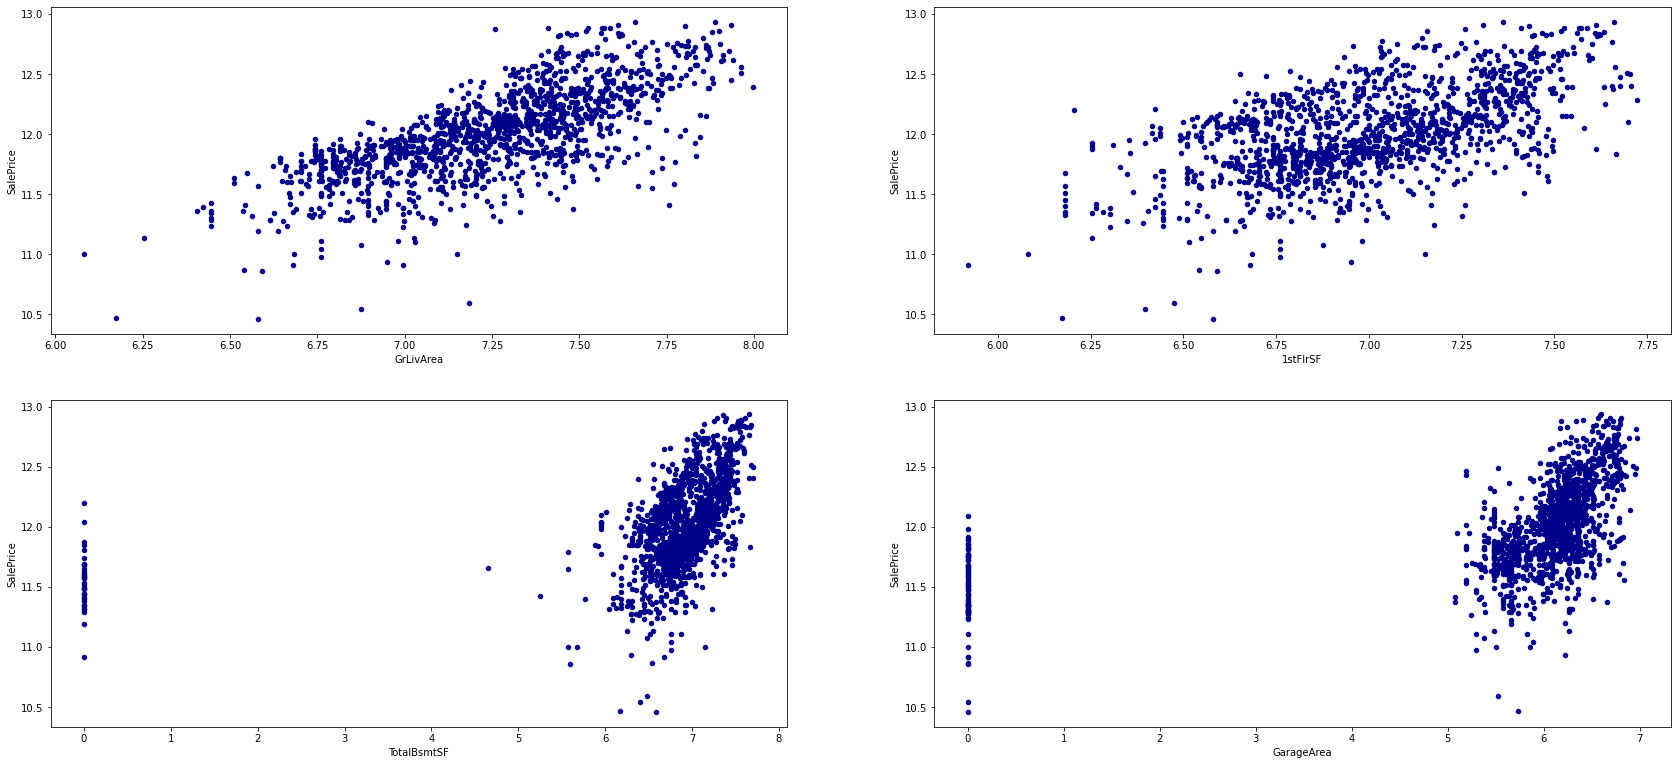

In [45]:
fig = plt.figure()

ax1= fig.add_subplot(2,2,1)
ax2= fig.add_subplot(2,2,2)
ax3= fig.add_subplot(2,2,3)
ax4= fig.add_subplot(2,2,4)

# Subplot 1

train_data.plot(kind='scatter', y='SalePrice', x= 'GrLivArea', ax= ax1   , figsize=(15,10), color='darkblue')
ax.set_title('GrLivArea vs Sale Price')
ax.set_xlabel('GrLivArea')
ax.set_ylabel('Sales Price')


# Subplot 2

train_data.plot(kind='scatter', y='SalePrice', x='1stFlrSF'    , ax= ax2   , figsize=(15,10), color='darkblue')
ax.set_title('1stFlrSF vs Sale Price')
ax.set_xlabel('1stFlrSF')
ax.set_ylabel('Sales Price')


#Subplot 3

train_data.plot(kind='scatter', y='SalePrice', x= 'TotalBsmtSF'   , ax= ax3   , figsize=(15,10), color='darkblue')
ax.set_title('TotalBsmtSF vs Sale Price')
ax.set_xlabel('TotalBsmtSF')
ax.set_ylabel('Sales Price')

#Subplot 4

train_data.plot(kind='scatter', y='SalePrice', x= 'GarageArea'   , ax= ax4   , figsize=(15,10), color='darkblue')
ax.set_title('TotalBsmtSF vs Sale Price')
ax.set_xlabel('TotalBsmtSF')
ax.set_ylabel('Sales Price')

plt.subplots_adjust(left=1, bottom=1, right=2.5, top=2, wspace=None, hspace=None)
plt.show()

Our hunch was correct. Ensuring normality solve the problems of heterocedasticity.
Let's continue with the other features

#### Group 2

We have said that 'HouseAge', 'LastRemodTime' and 'GarageAge' seem to have some kind of Fisher distribution. Unfortunately, we haven't discover a transformation that could give us a normal distribution yet. So in this case we apply a simple transformation we think we give some normality to our distributions.

The transformation we'll use it's the square root

In [46]:
import math

In [47]:
train_data['HouseAge']= train_data['HouseAge'].map(math.sqrt)
train_data['LastRemodTime']= train_data['LastRemodTime'].map(math.sqrt)
train_data['GarageAge']= train_data['GarageAge'].map(math.sqrt)

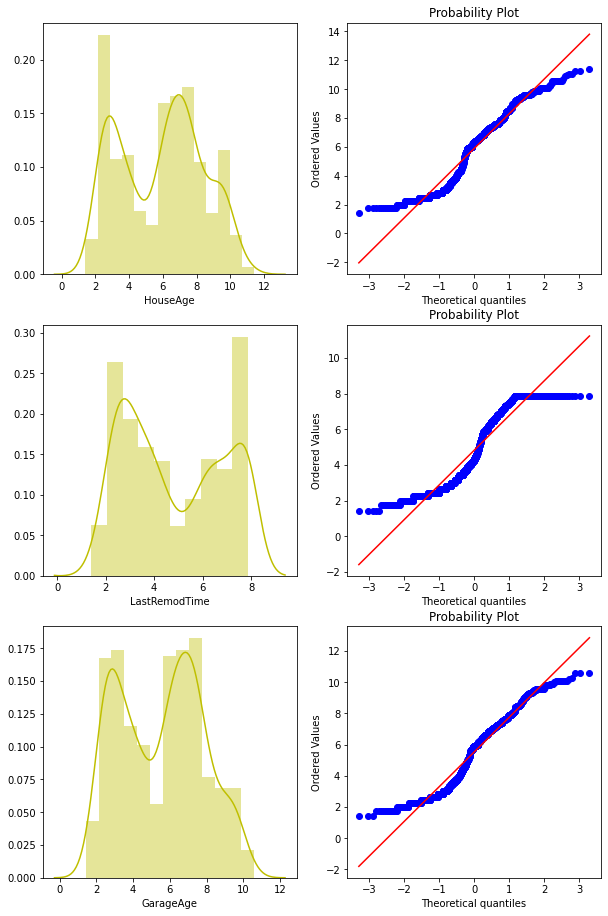

In [48]:
fig=plt.figure(figsize=(10,5))
ax1=fig.add_subplot(3,2,1)
ax2=fig.add_subplot(3,2,2)
ax3=fig.add_subplot(3,2,3)
ax4=fig.add_subplot(3,2,4)
ax5=fig.add_subplot(3,2,5)
ax6=fig.add_subplot(3,2,6)

sns.distplot(train_data['HouseAge'],color='y', ax= ax1)
probplot(train_data['HouseAge'], plot= ax2)

sns.distplot(train_data['LastRemodTime'],color='y', ax= ax3)
probplot(train_data['LastRemodTime'], plot= ax4)

sns.distplot(train_data['GarageAge'],color='y', ax= ax5)
probplot(train_data['GarageAge'], plot= ax6)

plt.subplots_adjust(left=None, bottom=None, right=None, top=2.5)

Let's see if we achieve some improvement

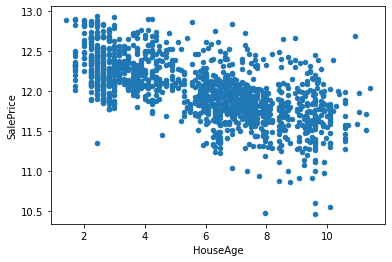

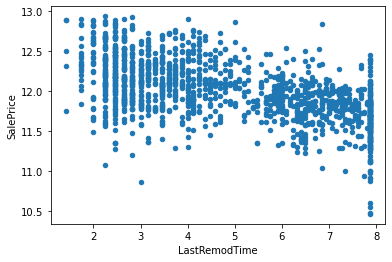

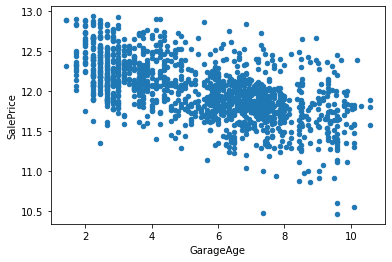

In [49]:
train_data.plot(kind='scatter', x='HouseAge', y='SalePrice')
train_data.plot(kind='scatter', x='LastRemodTime', y='SalePrice')
train_data.plot(kind='scatter', x='GarageAge', y='SalePrice')

It seems we reduce the variance of the variance. In other words, we have gotten more homoscedasticity.

With this we have concluded our analysis over the numerical features.

## Analyzing categorical features

In [50]:
train_data.shape

(1406, 50)

In [51]:
train_data.describe(include='object').sort_values(by='freq', axis=1, ascending=False)

,Utilities,Street,Condition2,RoofMatl,Heating,GarageCond,GarageQual,LandSlope,CentralAir,Functional,...,KitchenQual,HouseStyle,HeatingQC,BsmtQual,GarageFinish,Foundation,Exterior1st,Exterior2nd,BsmtFinType1,Neighborhood
count,1406,1406,1406,1406,1406,1406,1406,1406,1406,1406,...,1406,1406,1406,1406,1406,1406,1406,1406,1406,1406
unique,2,2,6,7,6,5,5,3,2,7,...,4,8,5,4,3,6,15,16,6,25
top,AllPub,Pave,Norm,CompShg,GasA,TA,TA,Gtl,Y,Typ,...,TA,1Story,Ex,TA,Unf,CBlock,VinylSd,VinylSd,Unf,NAmes
freq,1405,1401,1394,1385,1377,1354,1341,1334,1316,1310,...,724,707,706,668,668,623,494,483,454,222


At this point, we have almost 38 categorical features remaining in our dataset. It's a big number if we take into account that we need to convert them into dummies for beeing using in the regression model. 

Because our target variables is numerical (price), we will use the F-statics (ussing in the ANNOVA) to determine the best features.

ANNOVA is an analysis by wich we determine if the means (mean price in this case) of three o more groups(instances of a feature) are equal or different. To do this ANNOVA uses F-statics as a measure of the 'inequality' of the means. The bigger the F, the bigger the inequality.

If the different instance of a variable, e.g different types of garages, have the same sale price mean, we could say the type of garage does't affect the sale price. Otherwise if the different types of garanges have very different sale price mean, it's mean that this feature (garage type) have a strong impact on our target.

It order to reduce the number of features, we will carry out an ANNOVA analysis and choose the 10 features with the biggest F-statics.

In [52]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [53]:
#Getting categorical feature names

categorical_var=list(train_data.describe(include='object').columns)

# Creating a new dataframe to carry out the procedure

train_cat=train_data[categorical_var]
SalePrice=train_data[['SalePrice']]

The f_regression function just receive number as imput, so we need to transform the labels of our variables into numbers.

In [54]:
# Creating an encoder object
enc=LabelEncoder()

# Transforming labels into numbers

for var in categorical_var:
    train_cat[var]=enc.fit_transform(train_data[var])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Now, we will automatically carry out our selection through the SelecKBest funtion using the f_regression as the decision score function.

In [55]:
# Defining feature selection

fs = SelectKBest(score_func=f_regression, k=10)

# apply feature selection
selection = fs.fit_transform(train_cat, SalePrice)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Let's see our selected features

In [56]:
selection

array([[2, 2, 2, ..., 1, 1, 2],
       [3, 1, 2, ..., 1, 1, 2],
       [2, 2, 2, ..., 1, 1, 2],
       ...,
       [0, 4, 3, ..., 1, 1, 2],
       [3, 1, 3, ..., 1, 2, 2],
       [2, 1, 3, ..., 1, 0, 2]])

We've gotten an array with the values,but we need the name. So we deploy a function to get them.

In [57]:
# Transforming the array into a dataframe 
selection=pd.DataFrame(selection)
selection.head()

,0,1,2,3,4,5,6,7,8,9
0,2,2,2,0,1,4,2,1,1,2
1,3,1,2,0,1,4,3,1,1,2
2,2,2,2,0,1,4,2,1,1,2
3,3,0,3,2,1,4,2,5,2,2
4,2,2,2,0,1,4,2,1,1,2


We will compare the values of the columns in the selection dataframe with the values in the orginal dataframe and get the name of those colums where all the values match.

In [58]:
# Getting the names of the 

selected_features=[]

for i in range(10):
    for feat in train_cat.columns:
        comparison=np.where(selection.iloc[:,i] == train_cat.loc[:,feat], True, False)
        if comparison.all():
            selected_features.append(feat)


selected_features

['ExterQual',
 'Foundation',
 'BsmtQual',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'GarageType',
 'GarageFinish',
 'PavedDrive']

In fact, we need the name of the unselected features to be able to eliminate them from our train data set.

In [59]:
setA=set(selected_features)
setB=set(categorical_var)
setC=setB-setA
CatVarDeleted=list(setC)

Let's see the features we have to delete and drop them from our data set.

In [60]:
CatVarDeleted

['Exterior2nd',
 'GarageQual',
 'GarageCond',
 'BsmtFinType1',
 'LandContour',
 'HouseStyle',
 'LotConfig',
 'SaleType',
 'MSZoning',
 'Utilities',
 'Exterior1st',
 'Condition2',
 'MasVnrType',
 'Street',
 'Heating',
 'LandSlope',
 'RoofMatl',
 'BsmtCond',
 'Functional',
 'BsmtFinType2',
 'BldgType',
 'RoofStyle',
 'SaleCondition',
 'BsmtExposure',
 'Neighborhood',
 'ExterCond',
 'LotShape',
 'Condition1']

In [61]:
train_data.drop(labels=CatVarDeleted, axis=1, inplace=True)
train_data

,OverallQual,ExterQual,Foundation,BsmtQual,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,GrLivArea,...,TotRmsAbvGrd,GarageType,GarageFinish,GarageCars,GarageArea,PavedDrive,SalePrice,HouseAge,LastRemodTime,GarageAge
0,7,Gd,PConc,Gd,6.752270,Ex,Y,SBrkr,6.752270,7.444249,...,8,Attchd,RFn,2,6.306275,Y,12.247694,3.000000,3.000000,3.000000
1,6,TA,CBlock,Gd,7.140453,Ex,Y,SBrkr,7.140453,7.140453,...,6,Attchd,RFn,2,6.131226,Y,12.109011,6.000000,6.000000,6.000000
2,7,Gd,PConc,Gd,6.824374,Ex,Y,SBrkr,6.824374,7.487734,...,6,Attchd,RFn,2,6.410175,Y,12.317167,3.316625,3.162278,3.316625
3,7,TA,BrkTil,TA,6.628041,Gd,Y,SBrkr,6.867974,7.448334,...,7,Detchd,Unf,3,6.464588,Y,11.849398,9.848858,6.480741,3.741657
4,8,Gd,PConc,Gd,7.043160,Ex,Y,SBrkr,7.043160,7.695303,...,9,Attchd,RFn,3,6.728629,Y,12.429216,3.464102,3.464102,3.464102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,6,TA,PConc,Gd,6.859615,Ex,Y,SBrkr,6.859615,7.406711,...,7,Attchd,RFn,2,6.131226,Y,12.072541,3.605551,3.464102,3.605551
1402,6,TA,CBlock,Gd,7.340836,TA,Y,SBrkr,7.636752,7.636752,...,7,Attchd,Unf,2,6.214608,Y,12.254863,5.830952,4.898979,5.830952
1403,7,Ex,Stone,TA,7.049255,Ex,Y,SBrkr,7.080026,7.757906,...,9,Attchd,RFn,1,5.529429,Y,12.493130,8.426150,2.449490,8.426150
1404,5,TA,CBlock,TA,6.982863,Gd,Y,FuseA,6.982863,6.982863,...,5,Attchd,Unf,1,5.480639,Y,11.864462,7.874008,4.000000,7.874008


In [62]:
# Saving the list of selected features

Aux_DF= train_data.drop(labels='SalePrice', axis=1)
selected_feat=Aux_DF.columns

We have finished our features selection process. Now we have one last task before training our model. 

We have seen that one condition to use linear regression it's that all the data must be quantitative. To achieve this, we are going to transform our qualitative variables into dummies. Each dummie is a variable itsef that represent the presence or not of an instance of a categorical variables. For example if we have the feature color wich have two features, red and blue, and we get dummies from it, the output it will be two variables color_red and color_blue. If the sample is blue, the value in color_red will be 0 and the value in color_blue will be 1.

In [63]:
train_data=pd.get_dummies(train_data, drop_first=True)
train_data

,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,SalePrice,HouseAge,...,KitchenQual_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_P,PavedDrive_Y
0,7,6.752270,6.752270,7.444249,2,8,2,6.306275,12.247694,3.000000,...,0,1,0,0,0,0,1,0,0,1
1,6,7.140453,7.140453,7.140453,2,6,2,6.131226,12.109011,6.000000,...,1,1,0,0,0,0,1,0,0,1
2,7,6.824374,6.824374,7.487734,2,6,2,6.410175,12.317167,3.316625,...,0,1,0,0,0,0,1,0,0,1
3,7,6.628041,6.867974,7.448334,1,7,3,6.464588,11.849398,9.848858,...,0,0,0,0,0,1,0,1,0,1
4,8,7.043160,7.043160,7.695303,2,9,3,6.728629,12.429216,3.464102,...,0,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,6,6.859615,6.859615,7.406711,2,7,2,6.131226,12.072541,3.605551,...,1,1,0,0,0,0,1,0,0,1
1402,6,7.340836,7.636752,7.636752,2,7,2,6.214608,12.254863,5.830952,...,1,1,0,0,0,0,0,1,0,1
1403,7,7.049255,7.080026,7.757906,2,9,1,5.529429,12.493130,8.426150,...,0,1,0,0,0,0,1,0,0,1
1404,5,6.982863,6.982863,6.982863,1,5,1,5.480639,11.864462,7.874008,...,0,1,0,0,0,0,0,1,0,1


We have fishined our preprocessing stage

# Modeling

We'll use an simple linear regression model, in this case the we'll use the available one in the SK learn librery

In [64]:
# importing the model algorithm

from sklearn.linear_model import LinearRegression

In [65]:
y=train_data[['SalePrice']].values
X=train_data.drop(labels='SalePrice', axis=1)
X=X.values

In [66]:
# Creating the model

LinModel=LinearRegression()

# Training the model

LinModel.fit(X,y)

print('The model have been successfully created and trained')

The model have been successfully created and trained


# Preparing the test set

In [67]:
test_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


## Deleting features 

First of all, we'll filter our test set to get just the selected features

In [68]:
# Deleting unselected fueatures 

test_data.drop(labels= high_mv_feat, axis=1, inplace=True)
test_data.drop(labels= low_corr_feat, axis=1, inplace=True)
test_data.drop(labels= CatVarDeleted, axis=1, inplace=True)

## Dealing with missing values

Let's check if our set has missing values

In [69]:
test_data.isnull().sum()

OverallQual      0
YearBuilt        0
YearRemodAdd     0
ExterQual        0
Foundation       0
BsmtQual        44
TotalBsmtSF      1
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
GrLivArea        0
FullBath         0
KitchenQual      1
TotRmsAbvGrd     0
GarageType      76
GarageYrBlt     78
GarageFinish    78
GarageCars       1
GarageArea       1
PavedDrive       0
dtype: int64

The list of features with missing values is:'BsmtQual', 'TotalBsmtSF', 'KitchenQual', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea'.


For the vairables that present missing values in the train set, we are going to follow the same criteria. This is the case of 'GarageType' and 'GarageFinish' wich are going to be replacing by the most frequent value and 'GarageYrBlt' wich is going to be replace by the year of construction of the house.

In [70]:
# Replacing nan values based frecuency

test_data['GarageType'].fillna(value='Attchd', inplace=True)
test_data['GarageFinish'].fillna(value='Unf', inplace=True)

# Replacing nan based on other features

index=test_data[test_data['GarageYrBlt'].isnull()].index

for i in index:
    value=test_data.loc[i, 'YearBuilt']
    test_data.loc[i, 'GarageYrBlt']= value

Let's see the case of 'BasmtQual'.

In [71]:
test_data[test_data['BsmtQual'].isnull()].head(10)

,OverallQual,YearBuilt,YearRemodAdd,ExterQual,Foundation,BsmtQual,TotalBsmtSF,HeatingQC,CentralAir,Electrical,...,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,PavedDrive
125,3,1945,2007,TA,CBlock,NaN,0.0,TA,N,SBrkr,...,640,1,TA,5,Detchd,1945.0,Unf,1.0,240.0,N
133,4,1967,1967,TA,Slab,NaN,0.0,TA,Y,SBrkr,...,2650,3,TA,10,Attchd,1967.0,Unf,0.0,0.0,Y
269,6,1981,1981,TA,Slab,NaN,0.0,TA,Y,SBrkr,...,1882,2,TA,8,Attchd,1981.0,Unf,2.0,612.0,Y
318,5,1953,1953,TA,Slab,NaN,0.0,TA,Y,FuseA,...,1210,1,TA,7,Attchd,1953.0,Fin,1.0,616.0,Y
354,2,1940,1950,TA,BrkTil,NaN,0.0,Fa,N,FuseA,...,612,1,TA,4,Detchd,1965.0,Unf,1.0,308.0,N
387,2,1947,1950,TA,Slab,NaN,0.0,Fa,N,SBrkr,...,660,1,Fa,5,Attchd,1947.0,Unf,0.0,0.0,N
388,4,1954,1954,TA,CBlock,NaN,0.0,TA,Y,SBrkr,...,1383,1,TA,6,Attchd,1980.0,Unf,2.0,498.0,Y
396,5,1880,2007,Gd,PConc,NaN,0.0,Ex,Y,SBrkr,...,2016,1,TA,7,Attchd,1900.0,Unf,2.0,576.0,P
397,5,1979,1979,TA,Slab,NaN,0.0,TA,Y,SBrkr,...,2228,2,TA,8,Detchd,1979.0,Unf,2.0,720.0,Y
398,5,1979,1979,TA,Slab,NaN,0.0,TA,Y,SBrkr,...,1535,2,TA,8,Attchd,1979.0,Unf,2.0,400.0,Y


We could see most of values have a basement surface of 0. This could mean that these houses don´t have basement. Let's check if we include the non-basement option in our model

In [72]:
train_data.iloc[:, 19:30].head(1)

,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP
0,0,0,1,0,0,0,0,0,1,0,0


We haven't include this option so we must filling with another of the values available. We'll replace the missing values by most frequent value

In [73]:
# Determing the most frequent value

test_data['BsmtQual'].value_counts()

TA    634
Gd    591
Ex    137
Fa     53
Name: BsmtQual, dtype: int64

In [74]:
# Replacing missing values for the most frequent value

test_data.loc[test_data['BsmtQual'].isnull(), 'BsmtQual']= 'TA'

Because all the other variable present just 1 missing values, we will analyze case per case. Let's start with the 'GarageCars' case

In [75]:
test_data[test_data['GarageArea'].isnull()]

,OverallQual,YearBuilt,YearRemodAdd,ExterQual,Foundation,BsmtQual,TotalBsmtSF,HeatingQC,CentralAir,Electrical,...,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,PavedDrive
1116,5,1923,1999,TA,BrkTil,Gd,859.0,Ex,Y,SBrkr,...,1828,2,Gd,6,Detchd,1923.0,Unf,NaN,NaN,Y


We can see it corresponds to the missing value in 'GarageArea'. We will use the frecuency in 'GarageCars' and the mean in 'GarageArea'.

In [76]:
test_data['GarageCars'].value_counts()

2.0    770
1.0    407
3.0    193
0.0     76
4.0     11
5.0      1
Name: GarageCars, dtype: int64

In [77]:
# filling missing values

test_data.loc[test_data['GarageArea'].isnull(), 'GarageArea'] = round(test_data['GarageArea'].mean(),0)
test_data.loc[test_data['GarageCars'].isnull(), 'GarageCars'] = 2.0

Let's see the 'TotalBsmtSF' case

In [78]:
test_data[test_data['TotalBsmtSF'].isnull()]

,OverallQual,YearBuilt,YearRemodAdd,ExterQual,Foundation,BsmtQual,TotalBsmtSF,HeatingQC,CentralAir,Electrical,...,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,PavedDrive
660,4,1946,1950,TA,PConc,TA,NaN,TA,Y,FuseA,...,896,1,TA,4,Detchd,1946.0,Unf,1.0,280.0,Y


We can see it corresponds with a possible non-basement house. So will fill this value with 0

In [79]:
# replacing missing value

test_data.loc[test_data['TotalBsmtSF'].isnull(), 'TotalBsmtSF']= 0

In [80]:
# Finding most frequent value
test_data['KitchenQual'].value_counts()

TA    757
Gd    565
Ex    105
Fa     31
Name: KitchenQual, dtype: int64

In [81]:
test_data.loc[test_data['KitchenQual'].isnull(), 'KitchenQual'] = 'TA'

Checkpoint

In [82]:
print('The number of missing values is: ', test_data.isnull().sum().sum())

The number of missing values is:  0


## Applying trasformations

Seeking to fulfill the necessary conditions to use linear regression, we have apply some transformation to our train data set. The need to apply the same transformation to our test set.

Trying to apply the transformation we've notice there's wrong data in the column 'GarageYrBlt' of one sample. The garage appear to be constructed in the year 2207. We'll replace for the years of construction of the house

In [83]:
test_data.loc[test_data['GarageYrBlt']==2207, 'GarageYrBlt']= test_data.loc[test_data['GarageYrBlt']==2207, 'YearBuilt'].values[0]

In [84]:
# Applying log transformation

test_data['GrLivArea'] = np.log(test_data['GrLivArea'])
test_data['1stFlrSF'] = np.log(test_data['1stFlrSF'])

# Applying log transformation to values bigger than 0

test_data['TotalBsmtSF']=test_data['TotalBsmtSF'].map(SelectedLog)
test_data['GarageArea']=test_data['GarageArea'].map(SelectedLog)

# Transforming years into age and applying square root transofomation

test_data['HouseAge']=2012-test_data['YearBuilt']
test_data['LastRemodTime']= 2012-test_data['YearRemodAdd']
test_data['GarageAge']=2012-test_data['GarageYrBlt']

test_data['HouseAge']=test_data['HouseAge'].map(math.sqrt)
test_data['LastRemodTime']=test_data['LastRemodTime'].map(math.sqrt)
test_data['GarageAge']=test_data['GarageAge'].map(math.sqrt)

print('Transformations have been successfully permormed')

Transformations have been successfully permormed


 ## Getting dummies
 
When we trained our model we got k-1 dummies from the k instances of a features. We made it this way because the dummy number k  would be redundant.

When we apply the function, the order of the dogs is very likely to be different (the first dummy created it's the first instance that appear in the column of the feature). We will produce the k dummies and then select them in base of the train data set dummies, so we will get the right columns in the right order.

In [85]:
# Getting dummies

test_data= pd.get_dummies(test_data)
test_data.columns

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'HouseAge', 'LastRemodTime', 'GarageAge', 'ExterQual_Ex',
       'ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA', 'Foundation_BrkTil',
       'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Slab',
       'Foundation_Stone', 'Foundation_Wood', 'BsmtQual_Ex', 'BsmtQual_Fa',
       'BsmtQual_Gd', 'BsmtQual_TA', 'HeatingQC_Ex', 'HeatingQC_Fa',
       'HeatingQC_Gd', 'HeatingQC_Po', 'HeatingQC_TA', 'CentralAir_N',
       'CentralAir_Y', 'Electrical_FuseA', 'Electrical_FuseF',
       'Electrical_FuseP', 'Electrical_SBrkr', 'KitchenQual_Ex',
       'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA',
       'GarageType_2Types', 'GarageType_Attchd', 'GarageType_Basment',
       'GarageType_BuiltIn', 'GarageType_CarPort', 'GarageType_Detchd',
       'GarageFinish_Fin', 'GarageFinish_RFn', 'GarageFinish_Unf',
       '

In [86]:
# Getting the right columns 

columns= list(train_data.columns)
columns

['OverallQual',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'GarageCars',
 'GarageArea',
 'SalePrice',
 'HouseAge',
 'LastRemodTime',
 'GarageAge',
 'ExterQual_Fa',
 'ExterQual_Gd',
 'ExterQual_TA',
 'Foundation_CBlock',
 'Foundation_PConc',
 'Foundation_Slab',
 'Foundation_Stone',
 'Foundation_Wood',
 'BsmtQual_Fa',
 'BsmtQual_Gd',
 'BsmtQual_TA',
 'HeatingQC_Fa',
 'HeatingQC_Gd',
 'HeatingQC_Po',
 'HeatingQC_TA',
 'CentralAir_Y',
 'Electrical_FuseF',
 'Electrical_FuseP',
 'Electrical_Mix',
 'Electrical_SBrkr',
 'KitchenQual_Fa',
 'KitchenQual_Gd',
 'KitchenQual_TA',
 'GarageType_Attchd',
 'GarageType_Basment',
 'GarageType_BuiltIn',
 'GarageType_CarPort',
 'GarageType_Detchd',
 'GarageFinish_RFn',
 'GarageFinish_Unf',
 'PavedDrive_P',
 'PavedDrive_Y']

We have two problems with this list. The first problem is that 'SalePrice' should be dropped. The seccond it's 'Electrical_Mix' is not a dummies in our test set (surely because there's not house of this type in our test set), so we should create it.

In [87]:
# Removing 'SalePrice'

columns.remove('SalePrice')

# Creating electrical mix

test_data['Electrical_Mix']=0

In [88]:
X_test=test_data[columns].values

Our data set is ready.

# Predicting

In [89]:
prediction= LinModel.predict(X_test)
prediction

array([[11.63309792],
       [11.94578762],
       [12.03305286],
       ...,
       [11.91429115],
       [11.58919689],
       [12.31558384]])

In [90]:
Aux_df=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
Submission =  Aux_df[['Id']]
Submission['SalePrice']= prediction
Submission.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Id,SalePrice
0,1461,11.633098
1,1462,11.945788
2,1463,12.033053
3,1464,12.091175
4,1465,12.242673


In [91]:
Submission.loc[:,'SalePrice']= Submission['SalePrice'].map(math.exp)
Submission.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Id,SalePrice
0,1461,112769.130614
1,1462,154166.369385
2,1463,168224.194418
3,1464,178291.484782
4,1465,207455.673045


In [92]:
Submission.to_csv('Iowa_house_price1.csv', index=False)